In [1]:
!pip install gym
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [2]:
import gym
from gym import spaces
import numpy as np
from google.colab import widgets
import time
import random
from collections import deque
import copy
from statistics import mean
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# **Lunar Landing Environment**

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('Observation space: ', env.observation_space.shape)
print('Action space: ', env.action_space.n)

Observation space:  (8,)
Action space:  4


# Actor-Critic

In [4]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(8, 256)
        self.actor = nn.Linear(256, 4)
        self.critic = nn.Linear(256, 1)
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [5]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

In [6]:
def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []
    
    for r in model.rewards[::-1]:
        R = r + 0.96 * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()
        
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]

In [7]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=0.0099)
eps = np.finfo(np.float32).eps.item()

In [8]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
RewardStats= []
for i_episode in range(10000):
    state = env.reset()
    Total_reward = 0
    for t in range(1, 1000):
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        model.rewards.append(reward)
        Total_reward+= reward
        if done:
            break
    RewardStats.append(Total_reward)
    finish_episode()
    if i_episode % 100 == 0:
        print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
            i_episode, Total_reward, mean(RewardStats[-100:])
        ))
    if mean(RewardStats[-100:]) >= 195:
        print("Solved, Average reward is now {} ".format(
                mean(RewardStats[-100:])))
        break

Episode 0	Last Reward: -145.63	Average reward: -145.63
Episode 100	Last Reward: -63.52	Average reward: -259.94
Episode 200	Last Reward: -152.33	Average reward: -54.04
Episode 300	Last Reward: 192.39	Average reward: 51.10
Episode 400	Last Reward: 183.66	Average reward: 155.02
Solved, Average reward is now 195.40074336327234 


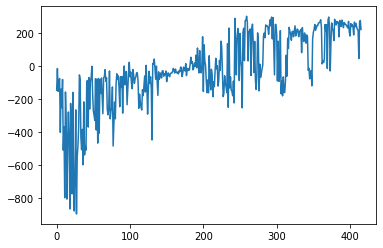

In [9]:
plt.plot(RewardStats)

In [10]:
test_rewards = []
for each_episode in range(10):
    obs = env.reset()
    done = False 
    t=0
    total_reward = 0
    print("Episode : ", each_episode)

    while(not done):
        t += 1
        action = select_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward = total_reward + reward
        
    test_rewards.append(total_reward)
    print("Total Reward in this episode : ", total_reward)

Episode :  0
Total Reward in this episode :  218.06420133302842
Episode :  1
Total Reward in this episode :  262.5693925992391
Episode :  2
Total Reward in this episode :  218.12006898367588
Episode :  3
Total Reward in this episode :  230.06144048818481
Episode :  4
Total Reward in this episode :  284.82618842387785
Episode :  5
Total Reward in this episode :  271.79382119813323
Episode :  6
Total Reward in this episode :  162.28604146971506
Episode :  7
Total Reward in this episode :  241.55590400244557
Episode :  8
Total Reward in this episode :  -17.60300047475826
Episode :  9
Total Reward in this episode :  235.6202666975762


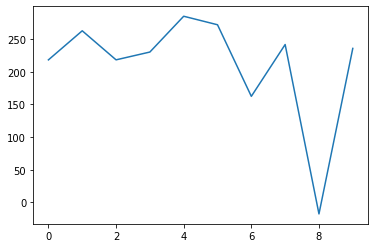

In [11]:
plt.plot(test_rewards)

In [12]:
test_rewards = []
for each_episode in range(10):
    obs = env.reset()
    done = False 
    t=0
    total_reward = 0
    print("Episode : ", each_episode)

    while(not done):
        t += 1
        action = select_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward = total_reward + reward
        
    test_rewards.append(total_reward)
    print("Total Reward in this episode : ", total_reward)

Episode :  0
Total Reward in this episode :  269.90332282776325
Episode :  1
Total Reward in this episode :  252.39079937302387
Episode :  2
Total Reward in this episode :  152.72449581485364
Episode :  3
Total Reward in this episode :  270.5257141064627
Episode :  4
Total Reward in this episode :  238.46402075110404
Episode :  5
Total Reward in this episode :  255.31368843474473
Episode :  6
Total Reward in this episode :  288.2298770422437
Episode :  7
Total Reward in this episode :  235.9708950944435
Episode :  8
Total Reward in this episode :  248.9512426257423
Episode :  9
Total Reward in this episode :  289.6572638718915


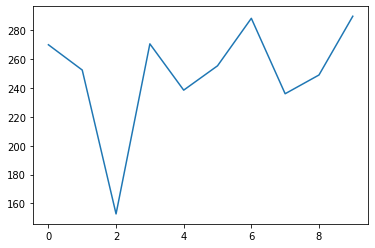

In [13]:
plt.plot(test_rewards)

In [17]:
from google.colab import files

torch.save(model, 'LL_A2C_Checkpoint.pth')
files.download('LL_A2C_Checkpoint.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>